<a href="https://colab.research.google.com/github/chinge55/nepali-currency-recognition/blob/master/Currency_Recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About the Project**

Usually image recognition tasks are done for a huge amount of data. In this project, I am trying to create a model using only 100 datasets belonging to 3 classes collectively. 

The task is **Nepali Currency Recognition** of 3 Nepali notes: Rs.50, Rs.10 and Rs. 100.  For this task, I am first going to use a feedforward CNN(LeNet like) model with a bunch of convolution layers followed by flatten layer and further by Dense layers. 



In [1]:
!git clone https://github.com/chinge55/nepali-currency-recognition

Cloning into 'nepali-currency-recognition'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 142 (delta 3), reused 0 (delta 0), pack-reused 130
Receiving objects: 100% (142/142), 159.35 MiB | 40.86 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import os
base_dir = 'nepali-currency-recognition/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_ten_dir = os.path.join(train_dir, 'ten')
train_fifty_dir = os.path.join(train_dir, 'fifty')
train_hundred_dir = os.path.join(train_dir, 'hundred')
test_ten_dir = os.path.join(test_dir, 'ten')
test_fifty_dir = os.path.join(test_dir, 'fifty')
test_hundred_dir = os.path.join(test_dir, 'hundred')


In [3]:
!mv nepali-currency-recognition/data/test/hundred/hundred.jpg nepali-currency-recognition/data/train/hundred/hundred.jpg

Usually, a good thing to do would be to rescale the data while they load from the *ImageDataGenerator()* but I am going to create a separate layer to do all the necessary pre-processings.

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split = 0.21)
test_datagen = ImageDataGenerator()

**For the Function below**
1. The **checkpoint** is used to save the model per epoch on the basis of validation dataset.
2. The **early_stopper** is used to stop the model if it doesn't doesn't get better and *patience* is to control that.

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def get_callbacks(model_name):
  checkpoint_path = 'model_checkpoints/checkpoint'+ model_name
  checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                             save_weights_only = True,
                             verbose = 1,
                             save_best_only = True
                            )
  early_stopper = EarlyStopping(monitor = 'val_loss',
                              patience = 5,
                              mode = 'auto')
  return (checkpoint, early_stopper)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical', subset = 'training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical', subset = 'validation')
test_generator = train_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical')

Found 80 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


In [7]:
IMG_SIZE = 150

In [8]:
num_classes = train_generator.num_classes
print(num_classes)

3


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [10]:
image, label = next(iter(train_generator))

The problem with having a few datasets is overfitting. So, in the hopes of solving that problem to some extent; some data augmentation is done. Image batch is taken and is augmented(random rotate, random flip, random crop and resampling). This layer has to do the augmentations on the training data but only rescale the data on the test data.

In [11]:
class RandomPreprocess(layers.Layer):
  def __init__(self, factor = 0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
    self.rescale = layers.experimental.preprocessing.Rescaling(1./255)
  def random_rotate_img(self, x):
    if  tf.random.uniform([]) < self.factor:
      x = tf.image.rot90(x)
    else:
      x
    return x
  def random_flip_img(self, x):
    x = tf.image.random_flip_left_right(x)
    return x
  def random_crop_pad(self, x):
    x = tf.image.resize_with_crop_or_pad(x, IMG_SIZE + 6, IMG_SIZE + 6) 
    x = tf.image.random_crop(x, size = [IMG_SIZE, IMG_SIZE, 3] )
    return x
  def call(self, X):
    output_list = []
    for i in range(X.shape[0]):
      x = X[i]
      x = self.random_rotate_img(x) 
      x = self.random_flip_img(x)
      x = self.random_crop_pad(x)
      x = self.rescale(x)
      output_list.append(x)
    return tf.stack(output_list)

In [12]:
random_images = RandomPreprocess()(image)
random_images.shape

TensorShape([10, 150, 150, 3])

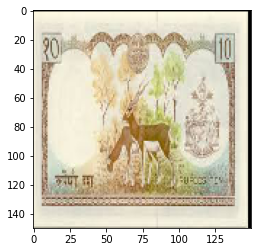

In [13]:
_ = plt.imshow(random_images[0])

In [14]:
#_ = plt.imshow((RandomPreprocess()(image)[0]))

IDK why the subclassing model doesn't work

In [15]:
# import tensorflow as tf
# class CustomModel(tf.keras.Model):
#   def __init__(self, units = 32):
#     super(CustomModel, self).__init__()
#     self.units = units
#     self.preprocessor = RandomPreprocess()
#     self.conv1 = layers.Conv2D(32, (3,3), activation = 'relu')
#     self.maxpool = layers.MaxPooling2D((2,2))
#     self.flatten = layers.Flatten()
#     self.dense = layers.Dense(units, activation = 'relu')
#     self.end_layer = layers.Dense(3, activation = 'softmax')
#   def call(self, x):
#     x = self.preprocessor(x)
#     x = self.conv1(x)
#     x = self.maxpool(x)
#     x = self.flatten(x)
#     x = self.dense(x)
#     x = self.end_layer(x)
#     return x
## The model doesn't build: The outputs are shown multiple

In [16]:
from keras import layers
from keras import models
tf.keras.backend.clear_session()

A fairly simple model. 
Decrease the first two dimensions, increase the third dimension, flatten them and use dense layer.

***Problem:*** *The model works only when the batch size is explicitly designed and is not robust to the changes in the batch size.* Eg. If I put the batch size = 10 and I get only 9 images, the model fails. This has to be solved. 

In [17]:
tf.keras.backend.clear_session()
images_input = tf.keras.Input(shape = (150, 150, 3), batch_size = 10)
aug_input = RandomPreprocess()(images_input)
x = layers.Conv2D(32, (3,3))(aug_input)
#x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3))(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation = 'relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation = 'relu')(x)
output = layers.Dense(3, activation = 'softmax')(x)
model = tf.keras.Model(images_input, output)
model.summary()
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = model_optimizer, metrics = ['acc'])


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(10, 150, 150, 3)]       0         
_________________________________________________________________
random_preprocess (RandomPre (10, 150, 150, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (10, 148, 148, 32)        896       
_________________________________________________________________
activation (Activation)      (10, 148, 148, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (10, 74, 74, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (10, 72, 72, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (10, 72, 72, 64)         

In [18]:
# model = models.Sequential()
# model.add(RandomPreprocess())
# model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(100, activation = 'relu'))
# model.add(layers.Dense(3, activation = 'softmax'))
# from keras import optimizers
# model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
# INPUT_SHAPE = (10, 150, 150, 3)
# model.build(INPUT_SHAPE)
# model.summary()

In [19]:
history = model.fit(train_generator,epochs = 20, callbacks = [get_callbacks('model_dense')], validation_data = validation_generator)


Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 1.6780 - acc: 0.3750
Epoch 00001: val_loss improved from inf to 1.04277, saving model to model_checkpoints/checkpointmodel_dense
8/8 [==============================] - 11s 1s/step - loss: 1.6780 - acc: 0.3750 - val_loss: 1.0428 - val_acc: 0.5000
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 1.0030 - acc: 0.5625
Epoch 00002: val_loss improved from 1.04277 to 1.01297, saving model to model_checkpoints/checkpointmodel_dense
8/8 [==============================] - 9s 1s/step - loss: 1.0030 - acc: 0.5625 - val_loss: 1.0130 - val_acc: 0.4500
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.9840 - acc: 0.4625
Epoch 00003: val_loss did not improve from 1.01297
8/8 [==============================] - 9s 1s/step - loss: 0.9840 - acc: 0.4625 - val_loss: 1.0492 - val_acc: 0.5000
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 1.0039 - acc: 0.6000
Epoch 00004: val_loss did not im

The model doesn't even train for 20 epochs. Seems like the model has very high variance (as expected with haveing a lack of datasets). Adding batchnormalization layers or dropout layers only seem to do the adverse effects on the model. 
Things that I could do:
1. Use weight decay. 

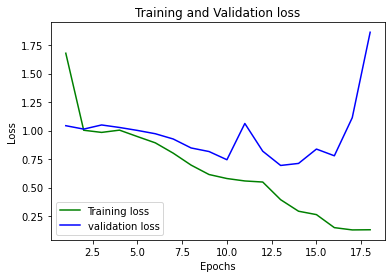

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(history.history['acc'])+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Pretty Standard Figure when you have a tiny validation set and a high learning rate except for the huge rise at the end.